In [108]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import *


In [109]:
import pickle
# Save model
def save_model(file_name, model):
    with open('model/'+file_name,'wb') as f:
        pickle.dump(model,f)
    f.close()

# Load model
def load_model(file_name):
    with open('model/'+file_name,'rb') as f:
        model = pickle.load(f)
    f.close()
    return model

In [110]:
#   Read raw data

#   Split data into train data and cross validation data
data_path = 'datasets\CIC IoT 2023\\'

x = [i for i in range(169)]
random.shuffle(x)

# Select random 1 file
train_file = x[-2:]       
print(f'Train files used: {train_file}')

# Select files for cross validation, total of 5 dataframe, each  contains 10 files
c = [x[i:i+10] for i in range(1,51,10)]

df = pd.read_csv(data_path+f'part-{train_file:05d}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv')
print(df.shape)


Train files used: 151
(229627, 47)


<Axes: >

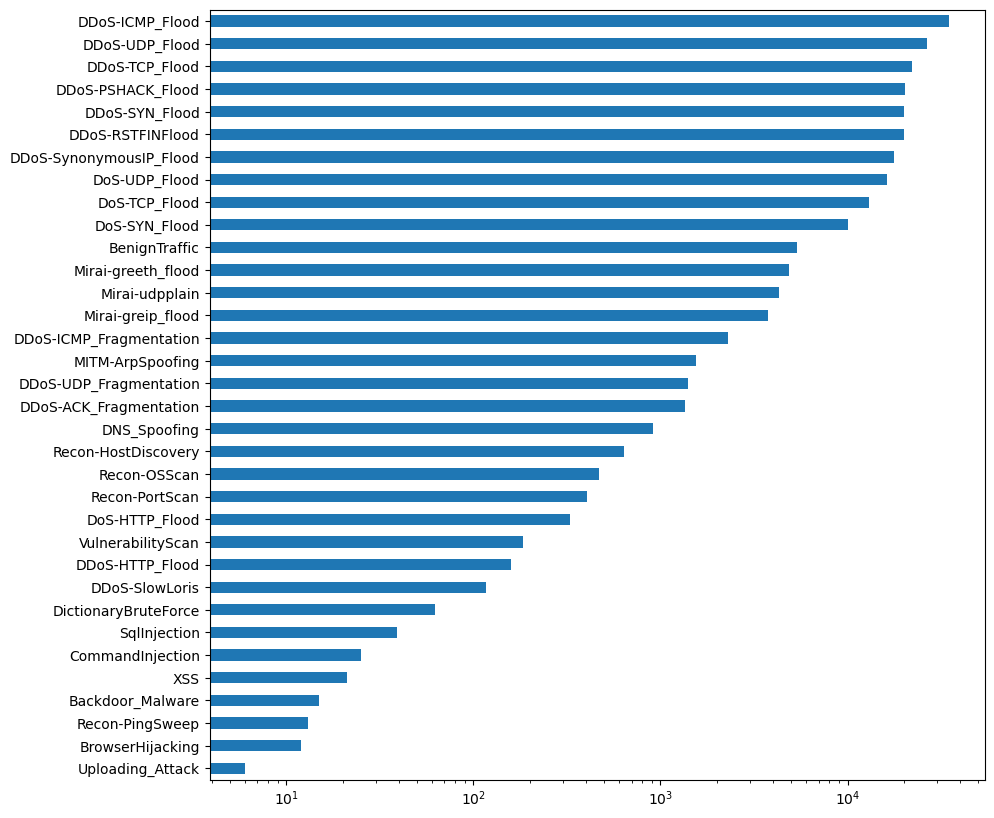

In [111]:
df['label'].value_counts(ascending=True).plot(kind='barh', figsize=(10,10), logx=True )

In [112]:
irrelevant_col = ['IAT']
single_value_cols = ['ece_flag_number', 'cwr_flag_number', 'Telnet', 'SMTP', 'IRC']
high_corr_cols = ['Srate', 'rst_flag_number', 'ack_count', 'fin_count', 'LLC', 'AVG', 'Magnitue', 'Std', 'Radius', 'AVG', 'Magnitue', 'Number', 'Weight']

In [113]:
df.drop(irrelevant_col,axis=1, inplace=True)             #    Drop all high correlated columns
df.drop(single_value_cols,axis=1, inplace=True)          #    Drop all single value columns 
df.drop(high_corr_cols,axis=1, inplace=True)             #    Drop all high correlated columns

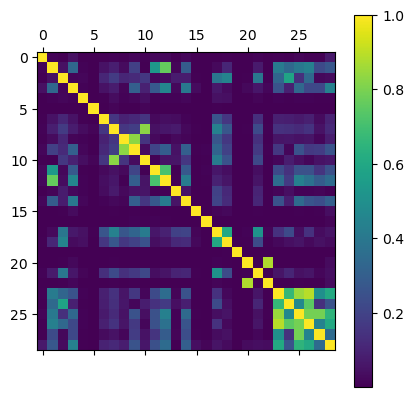

In [114]:
# Use this to get simplified correlation matrix 
corr =  df.iloc[:,:-1].corr().abs()
plt.matshow(corr)
plt.colorbar()
plt.show()

In [115]:
# remove nan, inf, -inf value
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)] 


In [116]:

# df.plot(y=['Protocol Type', 'Header_Length'],kind='line')    
# df['label'].value_counts().plot(kind='barh',figsize=(10,10),xlabel='Number of samples',ylabel='Type of attacks',title='Attacks count')
# plt.show()
# ddos = df[df.isin(['DDoS-ICMP_Flood','DDoS-RSTFINFlood','DDoS-SYN_Flood', 'DDoS-SynonymousIP_Flood', 'DDoS-UDP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-UDP_Fragmentation', 'DDoS-TCP_Flood', 'DDoS-ICMP_Fragmentation', 'DDoS-HTTP_Flood', 'DDoS-ACK_Fragmentation', 'DDoS-SlowLoris']).any(axis=1)]
# ddos['IAT'].plot(kind='kde')
# plt.show()

In [117]:

X = df.iloc[:,:-1].to_numpy()
Y = df.iloc[:,-1].to_numpy()

def convert_label_to_class_label(Y :np.ndarray):
    Y_class = []
    c = {'DDoS-ICMP_Flood': 'DDos', 'DDoS-RSTFINFlood': 'DDos', 'DDoS-SYN_Flood': 'DDos', 'DDoS-SynonymousIP_Flood': 'DDos', 'DDoS-UDP_Flood': 'DDos', 'DDoS-PSHACK_Flood': 'DDos', 'DDoS-UDP_Fragmentation': 'DDos', 'DDoS-TCP_Flood': 'DDos', 'DDoS-ICMP_Fragmentation': 'DDos', 'DDoS-HTTP_Flood': 'DDos', 'DDoS-ACK_Fragmentation': 'DDos', 'DDoS-SlowLoris': 'DDos', 'DoS-UDP_Flood': 'Dos', 'DoS-TCP_Flood': 'Dos', 'DoS-SYN_Flood': 'Dos', 'DoS-HTTP_Flood': 'Dos', 'Recon-HostDiscovery': 'Recon', 'Recon-PortScan': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PingSweep': 'Recon', 'VulnerabilityScan': 'Recon', 'Uploading_Attack': 'Recon', 'SqlInjection': 'Web-based', 'CommandInjection': 'Web-based', 'Backdoor_Malware': 'Web-based', 'XSS': 'Web-based', 'MITM-ArpSpoofing': 'Spoofing', 'DNS_Spoofing': 'Spoofing', 'BrowserHijacking': 'Spoofing', 'DictionaryBruteForce': 'Bruteforce', 'Mirai-greeth_flood': 'Mirai', 'Mirai-udpplain': 'Mirai', 'Mirai-greip_flood': 'Mirai', 'BenignTraffic': 'Benign'}
    for i in Y:
        Y_class.append(c[i])
    return np.array(Y_class)


Y_class = convert_label_to_class_label(Y)

In [118]:
# This data for training detailed network attack 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=random.randint(1,999))

# This data for training network attack by category
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X,Y_class,test_size=0.2, random_state=random.randint(1,999))

print(X_train.shape,X_test.shape)

(183701, 29) (45926, 29)


In [119]:
# Create model using SVM to classify specific attacks
# Use n_components='mle' to auto guess the dimension else speficy the dimension with int.

SVM_class_clf = make_pipeline(PCA(whiten=True, n_components='mle', svd_solver='full'),StandardScaler(), SGDClassifier(class_weight='balanced'))
SVM_class_clf.fit(X_train_class, Y_train_class)               

save_model('SVM_class.pkl', SVM_class_clf)

In [120]:
SVM_Y_predict_class = SVM_class_clf.predict(X_test_class)
print(accuracy_score(Y_test_class, SVM_Y_predict_class))
print(confusion_matrix(Y_test_class, SVM_Y_predict_class))

0.7667987632278013
[[  335   196     1     3     0   189    63   328]
 [    3     4     0     0     0     3     0     3]
 [   24    37 28127  4578     0   318    85   263]
 [   14     7  3629  3866     2   260   115    39]
 [    3     5     0     0  2609     4    12     4]
 [   21    81    15     6     0    71     9    94]
 [   49    66     3     8     4    73   194    88]
 [    1     0     0     0     0     1     3    10]]


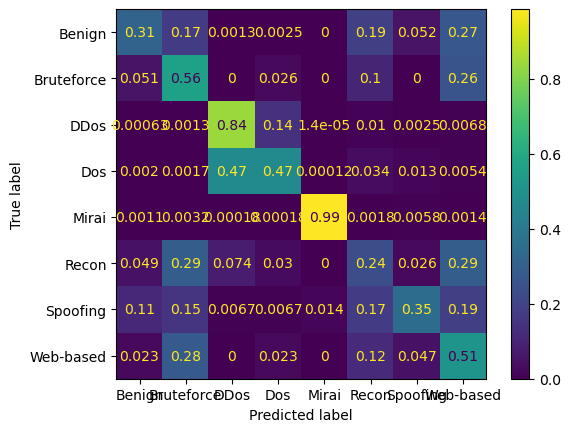

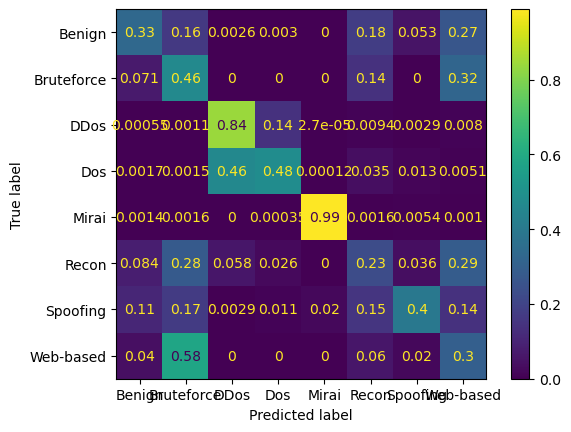

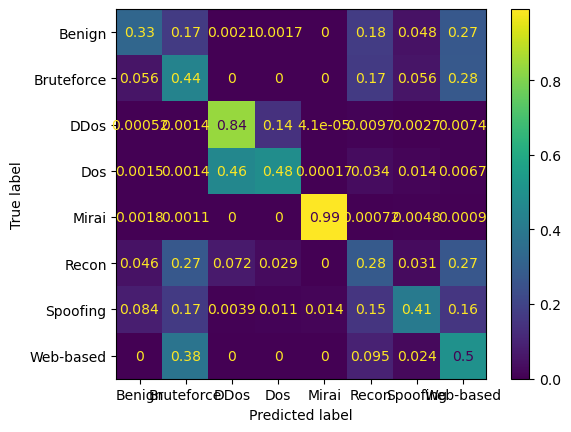

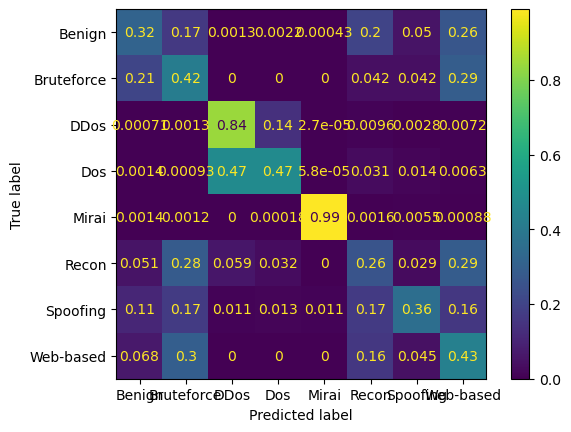

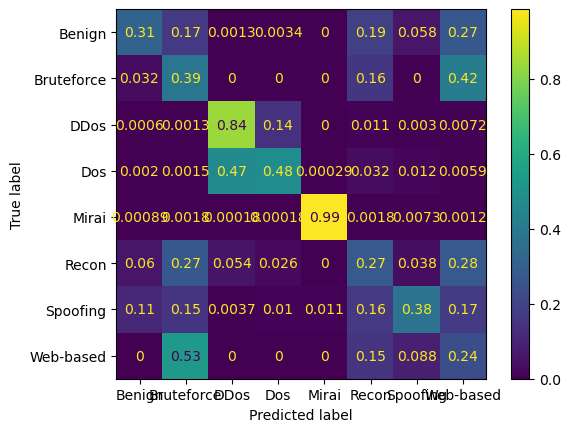

In [122]:
for i in c:
    cross_df = pd.concat([pd.read_csv(data_path+f'part-{j:05d}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv') for j in i]).sample(100000)
    cross_df.drop(irrelevant_col,axis=1, inplace=True)             #    Drop all high correlated columns
    cross_df.drop(single_value_cols,axis=1, inplace=True)          #    Drop all single value columns 
    cross_df.drop(high_corr_cols,axis=1, inplace=True)             #    Drop all high correlated columns
    X_cross = cross_df.iloc[:,:-1].to_numpy()
    Y_cross = convert_label_to_class_label(cross_df.iloc[:,-1].to_numpy())
    Y_pred = SVM_class_clf.predict(X_cross)
    # print(classification_report(Y_cross, Y_pred))
    ConfusionMatrixDisplay.from_predictions(Y_cross, Y_pred, normalize='true',fmt='.2f')

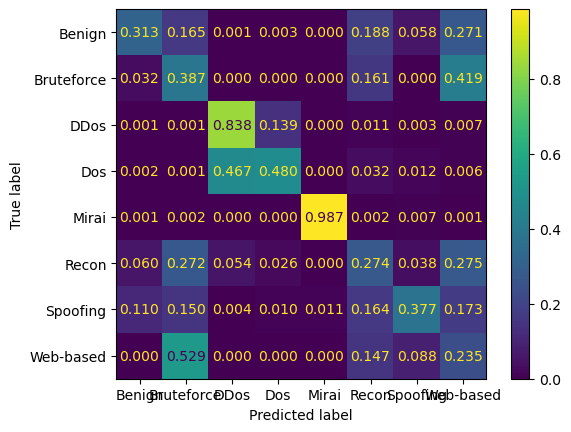

In [126]:
ConfusionMatrixDisplay.from_predictions(Y_cross, Y_pred, normalize='true',values_format='.3f')